In [47]:
import numpy as np                                      
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import seaborn as sns
import scipy.signal as signal 
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import pandas as pd
from scipy.signal import welch
from sklearn.decomposition import FastICA
import mne
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import make_pipeline
# from pyriemann.estimation import ERPCovariances
# from pyriemann.classification import MDM
from sklearn.metrics import confusion_matrix
# import svm classifier
from sklearn.svm import SVC

In [48]:
# Define our filter variables
fs = 512                      # Hz; sampling rate
dt = 1000. / fs                 # ms; time between samples
sdt = dt#np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 20.                        # Hz; our high cut for our bandpass
num_taps = 31                   # Number of taps/coefficients of FIR filter

# Create our filter coefficients
# Note: by defining 'fs' we don't divide our windows by the Nyquist
# Note: for FIR filters, a is always 1
b = signal.firwin(numtaps=num_taps, cutoff=[hp, lp], pass_zero='bandpass', fs=fs)
a = 1

# Define ERP-related variables
epoch_start = 0    # ms
epoch_end = 800    # ms
baseline_start = 0 # ms
baseline_end = 100 # ms
erp_start = 0    # ms
erp_end = 800      # ms

# Let's translate these from time into index space to save time later
e_s = np.round(epoch_start / sdt).astype(int)     # epoch start
e_e = np.round(epoch_end / sdt).astype(int)       # epoch end
bl_s = np.round(baseline_start / sdt).astype(int) # baseline start
bl_e = np.round(baseline_end / sdt).astype(int)   # baseline end
erp_s = np.round(erp_start / sdt).astype(int)     # ERP component window start
erp_e = np.round(erp_end / sdt).astype(int)       # ERP component window end

In [49]:
def max_abs_peak(x):
    x_copy = np.copy(x)
    x_copy = x_copy - np.mean(x_copy)
    return np.max(np.abs(x_copy))

def count_abnormal_points(x):
    x_copy = np.copy(x)
    x_copy = x_copy - np.mean(x_copy)
    # get sd of the signal
    x_sd = np.std(x_copy)
    threshold = 5 * x_sd
    return np.sum(np.abs(x_copy) > threshold)

def percent_abnormal_points(x):
    return count_abnormal_points(x) / x.shape[0] * 100

def ica_rm_artifacts(raw):
    n_cmp = 12
    ica = ICA(n_components=n_cmp, random_state=37, max_iter='auto')
    ica.fit(raw)
    exclude = []
    # get the first component
    sources = ica.get_sources(raw).get_data()
    # print("this is sources1!!!!!!")
    # print(sources.shape)
    for i in range(n_cmp):
        if count_abnormal_points(sources[i]) > 10 or max_abs_peak(sources[i]) > 5:
            exclude.append(i)
            # print('Component {} is excluded------'.format(i), str(
            #     count_abnormal_points(sources[i])), max_abs_peak(sources[i]), 
            #     np.std(sources[i]))
    ica.exclude = exclude
    ica.apply(raw)
    
def get_epoches(raw, y, y_start_index, epoch_start_i, epoch_end_i):
    fs = raw.info['sfreq']
    next_starting_index = y_start_index + y.shape[0]
    x = raw.get_data()
    num_channels = x.shape[0]
    event_onsets = np.where(y != 0)[0]
    print("count event onset---", event_onsets.shape ,np.unique(y, return_counts=True))
    if (len(event_onsets) == 0):
        print('No event onsets')
        return None, None, next_starting_index
    if (event_onsets[-1] + epoch_end_i > raw.n_times):
        next_starting_index = event_onsets[-1] + y_start_index
        event_onsets = event_onsets[:-1]
    if (len(event_onsets) == 0):
        print('No event onsets')
        if epoch_start_i < 0:
            next_starting_index += epoch_start_i
        return None, None, next_starting_index
    
    #ret_x = np.array((0, num_channels, epoch_end_i - epoch_start_i))
    ret_x = []
    ret_y = np.array([])
    for i in range(len(event_onsets)):
        s = event_onsets[i] + epoch_start_i
        e = event_onsets[i] + epoch_end_i
        if s < 0:
            print('error: get_epoches: the start index is less than 0')
            continue
        if e > raw.n_times:
            # print('error: get_epoches: the end index is greater than the length of the signal', e, raw.n_times, event_onsets[i], epoch_end_i,
            #       len(event_onsets))
            break
        ret_x.append(x[:, s:e])
        #ret_x[-1] = ret_x[-1] - np.mean(ret_x[-1], axis=1).reshape(num_channels, 1) # normalize
        ret_y = np.append(ret_y, y[event_onsets[i]])
    # normalize every epoch
    ret_x = np.array(ret_x)
    print("from get_epoches: ret_x.shape: ", ret_x.shape)
    print("from get_epoches: get the unique of ret_y", np.unique(ret_y, return_counts=True)) ########DEBUG
    return ret_x, ret_y, next_starting_index  # ret_x.shape = (index_epoches, num_channels, epoch_length)
        
    

def ica_every30s_then_epoch(raw, y):
    fs = raw.info['sfreq']
    s = int(2*fs)
    e = int(30 * fs) + s
    length = raw.n_times
    print("raw lenght: ", length)
    ret_x = None
    ret_y = np.array([])
    while True:
        end_time = e/fs
        if end_time > raw.times[-1]:
            end_time = raw.times[-1]
        raw_copy = raw.copy().crop(s/fs, end_time)
        #print('------!!!!!------ica_every30s_then_epoch: ', s/fs, e/fs, raw_copy.n_times)
        ica_rm_artifacts(raw_copy)
        print("before epoching: s and e index", s, e)
        tmp_x, tmp_y, s = get_epoches(raw_copy, y[s:e], s, e_s, e_e)
        e += int(30 * fs)
        #e = s + int(30 * fs)
        print("after epoching: s and e index", s, e)
        if e >= length:
            break
        if e + 30 * fs >= length:
            e = length
        if tmp_x is None or tmp_y is None:
            continue
    
        if ret_x is None:
            ret_x = tmp_x
        else:
            ret_x = np.concatenate((ret_x, tmp_x), axis=0)
        ret_y = np.concatenate((ret_y, tmp_y), axis=0)
        del tmp_x, tmp_y
        if (ret_y.shape[0] >= 1000):
            print("DEBUG: get enough data", ret_x.shape, ret_y.shape)
            break # debug
    return ret_x, ret_y  # ret_x.shape = (index_epoches, num_channels, epoch_length)

In [50]:
def get_epoches_from_bi2015a(filename):
    headerNames = pd.read_csv('./datasets/bi2015a/Header.csv', header=None)
    headerNames = np.array(headerNames.iloc[0]).flatten()
    if not Path(filename).exists():
        raise ValueError("File does not exist   " + filename)
    df = pd.read_csv(filename, header=None)
    df.columns = headerNames
    del headerNames
    sample_rate = 512
    x = df.iloc[:, 1:33].values
    print(x.shape)
    df = df.iloc[:, -2:]
    df['y'] = 0
    df.loc[df['Trigger'] == 1, 'y'] = -1
    df.loc[df['Target'] == 1, 'y'] = 1
    y = df.y.values
    del df
    chnames = ['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'F4',
            'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3',
            'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6',
            'P7', 'P3', 'Pz', 'P4', 'P8', 'PO7', 'O1', 'Oz',
            'O2', 'PO8', 'PO9', 'PO10']
            #'STI 014']
    
    info = mne.create_info(ch_names=chnames, sfreq=512, ch_types='eeg')
    m = mne.channels.make_standard_montage('standard_1020')
    x = mne.io.RawArray(x.T, info)
    x.set_montage(m)
    
    x.filter(0.5, 24)
    
    ret_x, ret_y = ica_every30s_then_epoch(x, y)
    # not work well
    # import util as myUtil
    # ret_x, ret_y = myUtil.epoch_wrt_event_chanFirst(x.get_data(), y, 0, int(0.8*512))
    
    return ret_x, ret_y

In [51]:
x, y = get_epoches_from_bi2015a('./datasets/bi2015a/subject_01_session_02.csv')
x.shape, y.shape

(404672, 32)
Creating RawArray with float64 data, n_channels=32, n_times=404672
    Range : 0 ... 404671 =      0.000 ...   790.373 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 3381 samples (6.604 sec)

raw lenght:  404672


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 12 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 9 ICA components
    Projecting back using 32 PCA components
before epoching: s and e index 1024 16384
count event onset--- (36,) (array([-1,  0,  1]), array([   30, 15324,     6]))
from get_epoches: ret_x.shape:  (36, 32, 410)
from get_epoches: get the unique of ret_y (array([-1.,  1.]), array([30,  6]))
after epoching: s and e index 16384 31744
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 12 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 10 ICA components
    Projecting back using 32 PCA components
before epoching: s and e index 16384 31744
count event onset--- (96,) (array([-1,  0,  1]), array([   80, 15264,    16]))
from ge

((1019, 32, 410), (1019,))

-1.0


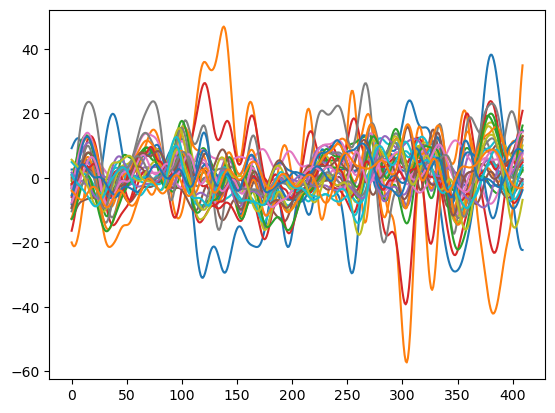

In [52]:
i = 160
plt.plot(x[i].T)
print(y[i])
plt.show()

In [53]:
# # save x and y to file
# import pickle
# with open("./perf-x.pkl", "wb") as f:
#     pickle.dump(x, f)
# with open("./perf-y.pkl", "wb") as f:
#     pickle.dump(y, f)

In [54]:
# pre-processing, inplace
def preprocess(x):
    for i in range(x.shape[0]):
        # correct DC offset of signal
        x[i] = x[i] - np.mean(x[i], axis=1).reshape(-1, 1)
        
        sd_every_chan = np.std(x[i], axis=1).reshape(-1, 1)
        x[i] = x[i] / sd_every_chan
        
        # bandpass filter
        #x[i] = signal.filtfilt(b, a, x[i], axis=1)
        #baseline correction
        #x[i] = x[i] - np.mean(x[i][bl_s:bl_e], axis=0)

preprocess(x)

In [55]:
X = x.copy()
y = y

num_points = 16; # we will divide our window into num_points means
# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    num_chans = x.shape[1] # assumes last dim is num channels
    len_time = x.shape[2] # assumes second dim is time
    w = np.round((end-start)/num_points).astype(int)
    y = np.zeros((num_trials, num_chans, num_points))
    for i in range(0, num_points):
        s = start + (w * i)
        e = s + w
        if e > len_time:
            e = len_time
        y[:,:,i] = np.mean(x[:,:,s:e], axis=2)
    return y

print(X.shape)
print(wm(X, 0, X.shape[2], num_points).shape)
X = wm(X, 0, X.shape[2], num_points)

(1019, 32, 410)
(1019, 32, 16)


In [56]:
X = X.reshape(X.shape[0], -1)
X = np.nan_to_num(X)
print(np.unique(y, return_counts=True))
print(np.isnan(X).any())
print(X.shape)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
clf = LinearDiscriminantAnalysis()
#clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(n_estimators=80, max_depth=4, random_state=0)
print(cross_val_score(clf, X_train, y_train, cv=cv, scoring = 'roc_auc').mean())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
print(np.unique(y_test, return_counts=True))
print(np.unique(y_pred, return_counts=True))
print("tn, fp, fn, tp", confusion_matrix(y_train, y_pred).ravel())
correct_count = 0
for gt, p in zip(y_train, y_pred):
    if gt == p:
        correct_count += 1
print("accuracy for training: ", correct_count / len(y_train))

(array([-1.,  1.]), array([850, 169]))
False
(1019, 512)
0.6879068507236888
(array([-1.,  1.]), array([86, 16]))
(array([-1.,  1.]), array([767, 150]))
tn, fp, fn, tp [758   6   9 144]
accuracy for training:  0.9836423118865867


In [57]:
y_pred = clf.predict(X_test)
print(np.unique(y_test, return_counts=True))
print(np.unique(y_pred, return_counts=True))
print("tn, fp, fn, tp", confusion_matrix(y_test, y_pred).ravel())
correct_count = 0
for gt, p in zip(y_test, y_pred):
    if gt == p:
        correct_count += 1
print("accuracy for training: ", correct_count / len(y_test))

(array([-1.,  1.]), array([86, 16]))
(array([-1.,  1.]), array([81, 21]))
tn, fp, fn, tp [71 15 10  6]
accuracy for training:  0.7549019607843137
